PLAN DU PROJET : 

- trouver les équations et les coder

- les réosudre de différentes manieres : 

1. Euler

2. Runge-Kunta q = 2

3. Runge-Kunta q = 4

- Comparer avec les solutions du rapport

- Étudier les constantes de stabilité dans chaque cas

- Étudier la consistance des solutions dans chaque cas 

- Conclure quant à la fiabilité des solutions données

LES DIFFÉRENTES VARIABLES QUI NOUS INTÉRESSENT ET DONT ON DOIT TROUVER L'ÉVOLUTION

- ATMOSPHERE

- CARBONATE ROCK

- DEEP OCEAN

- FOSSIL FUEL CABRONATE

- PLANT

- SOIL

- OCEAN SURFACE

- VEG LAND AREA



I. DIFFÉRENTES ÉQUATIONS RÉGISSANT LE CYCLE DU CARBONE

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Initial conditions
Atmosphere_Initial = 750
CarbonateRock_Initial = 100000000
DeepOcean_Initial = 38000
FossilFuel_Initial = 7500
Plant_Initial = 560
Soil_Initial = 1500
SurfaceOcean_Initial = 890
VegLandArea_percent_Initial = 100

x0 = np.array([Atmosphere_Initial,
               CarbonateRock_Initial,
               DeepOcean_Initial,
               FossilFuel_Initial,
               Plant_Initial,
               Soil_Initial,
               SurfaceOcean_Initial,
               VegLandArea_percent_Initial
               ])

# Constants
Alk = 2.222446077610055
Kao = .278
SurfOcVol = .0362
Deforestation = 0

# Helper functions
def AtmCO2(Atmosphere):
    return Atmosphere * (280/Atmosphere_Initial)
def GlobalTemp(AtmCO2):
    return 15 + ((AtmCO2-280) * .01)
def CO2Effect(AtmCO2):
    return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
def WaterTemp(GlobalTemp):
    return 273+GlobalTemp
def TempEffect(GlobalTemp):
    return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
def SurfCConc(SurfaceOcean):
    return (SurfaceOcean/12000)/SurfOcVol
def Kcarb(WaterTemp):
    return .000575+(.000006*(WaterTemp-278))
def KCO2(WaterTemp):
    return .035+(.0019*(WaterTemp-278))
def HCO3(Kcarb, SurfCConc):
    return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
def CO3(HCO3):
    return (Alk-HCO3)/2
def pCO2Oc(KCO2, HCO3, CO3):
    return 280*KCO2*(HCO3**2/CO3)


# Fossil fuels
FossFuelData = np.array([[50.0, 0.00], [75.0, 0.30], [100.0, 0.60], [125.0, 1.35], [150.0, 2.85], [175.0, 4.95], [200.0, 7.20], [225.0, 10.05], [250.0, 14.85], [275.0, 20.70], [300.0, 30.00]])
def FossilFuelsCombustion(t):
    i = 0
    if t >= FossFuelData[-1,0]:
        return FossFuelData[-1,1]
    while i + 1 < len(FossFuelData) and t >= FossFuelData[i,0]:
        i = i + 1
    if i == 0:
        return FossFuelData[0,1]
    else:
        return FossFuelData[i-1,1] + (t - FossFuelData[i-1,0]) / (FossFuelData[i,0] - FossFuelData[i-1,0]) * (FossFuelData[i,1] - FossFuelData[i-1,1])

def derivative(x, t):
    Atmosphere = x[0]
    CarbonateRock = x[1]
    DeepOcean = x[2]
    FossilFuelCarbon = x[3]
    Plants = x[4]
    Soils = x[5]
    SurfaceOcean = x[6]
    VegLandArea_percent = x[7]

    PlantResp = (Plants * (55/Plant_Initial)) + Deforestation/2
    Litterfall = (Plants* (55/Plant_Initial))+(Deforestation/2)
    SoilResp = Soils * (55/Soil_Initial)
    Volcanoes = 0.1
    AtmCO2_ = AtmCO2(Atmosphere)
    GlobalTemp_ = GlobalTemp(AtmCO2_)
    WaterTemp_ = WaterTemp(GlobalTemp_)
    Photosynthesis = 110 * CO2Effect(AtmCO2_) * (VegLandArea_percent/100) * TempEffect(GlobalTemp_)
    HCO3_ = HCO3(Kcarb(WaterTemp_), SurfCConc(SurfaceOcean))
    pCO2Oc_ = pCO2Oc(KCO2(WaterTemp_), HCO3_, CO3(HCO3_))
    AtmOcExchange = Kao*(AtmCO2_-pCO2Oc_)
    if x[3] > 0:
        FossilFuelsCombustion_ = FossilFuelsCombustion(t)
    else:
        FossilFuelsCombustion_ = 0
    dAtmosphere_dt = (PlantResp + SoilResp + Volcanoes + FossilFuelsCombustion_
                          - Photosynthesis - AtmOcExchange)

    Sedimentation = DeepOcean * (0.1/DeepOcean_Initial)
    dCarbonateRock_dt = Sedimentation - Volcanoes

    Downwelling = SurfaceOcean*(90.1/SurfaceOcean_Initial)
    Upwelling = DeepOcean * (90/DeepOcean_Initial)
    dDeepOcean_dt= Downwelling - Sedimentation - Upwelling

    dFossilFuelCarbon_dt = - FossilFuelsCombustion_

    dPlants_dt = Photosynthesis - PlantResp - Litterfall

    dSoils_dt = Litterfall - SoilResp

    dSurfaceOcean_dt = Upwelling + AtmOcExchange - Downwelling

    Development = (Deforestation/Plant_Initial * 0.2) * 100
    dVegLandArea_percent_dt = - Development

    derivative = np.array([
        dAtmosphere_dt,
        dCarbonateRock_dt,
        dDeepOcean_dt,
        dFossilFuelCarbon_dt,
        dPlants_dt,
        dSoils_dt,
        dSurfaceOcean_dt,
        dVegLandArea_percent_dt
        ])

    return derivative



II. RÉSOLUTION AVEC EULER

/var/folders/q4/80y3jscj6_50mbqqrvpsf7h00000gn/T/ipykernel_70704/19403556.py:48: RuntimeWarning: invalid value encountered in sqrt
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)


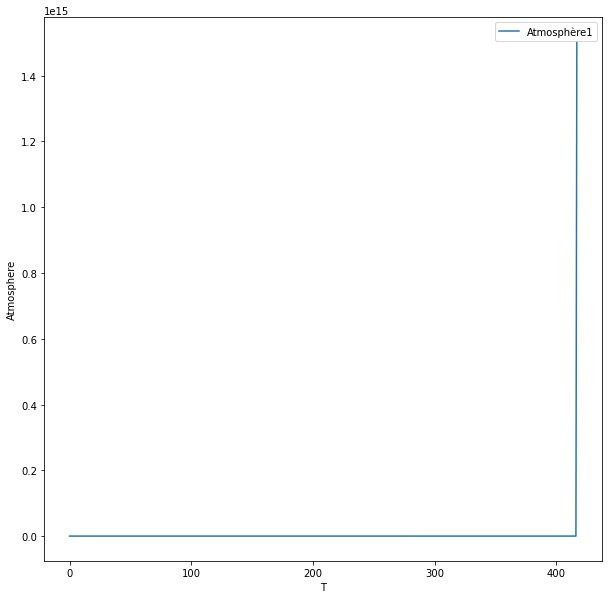

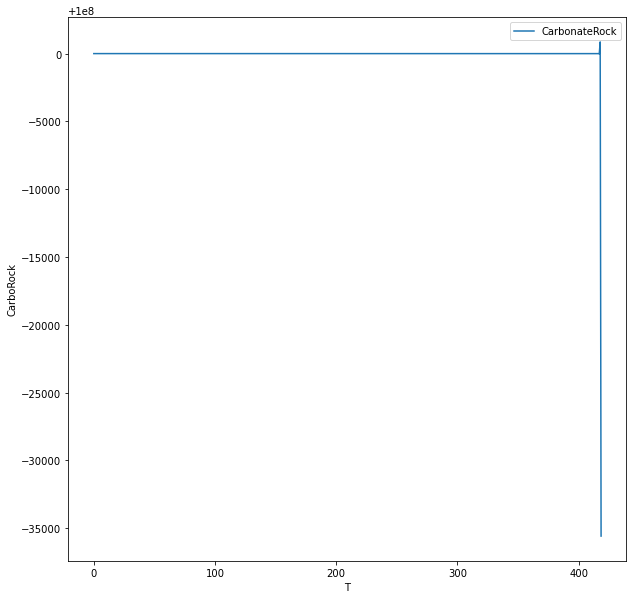

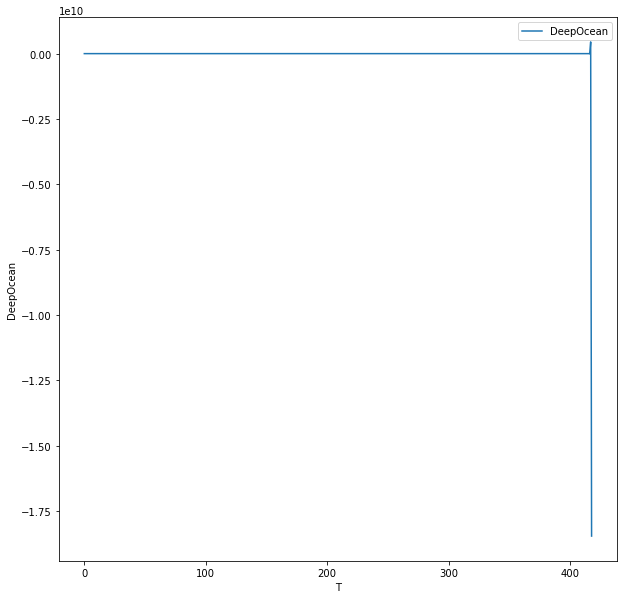

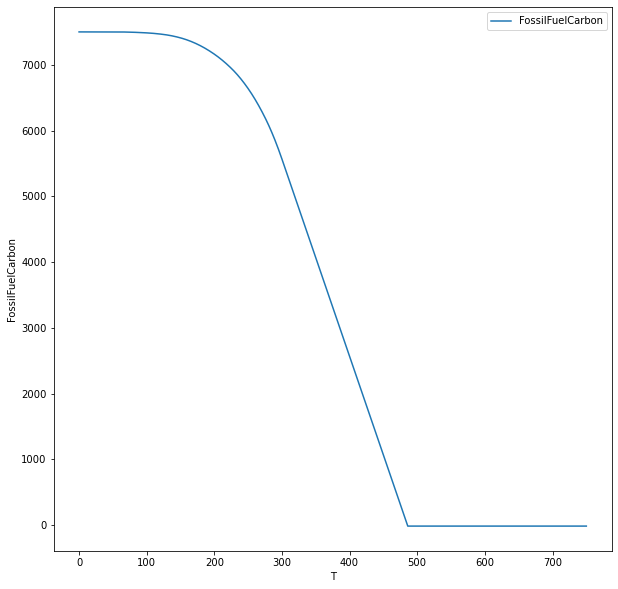

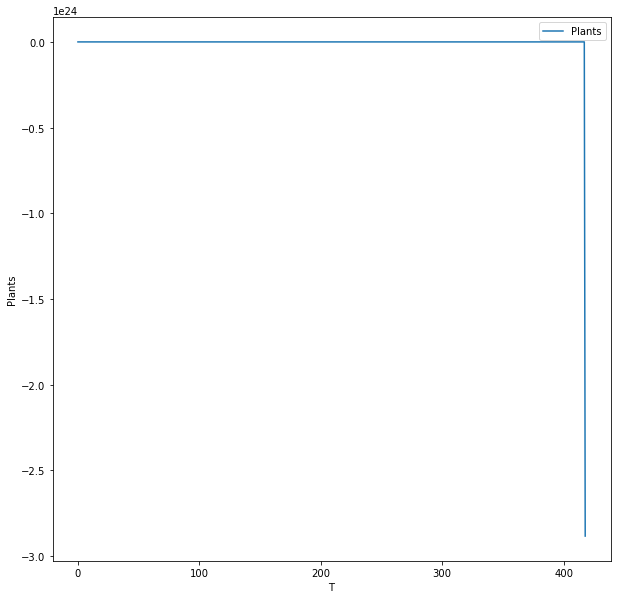

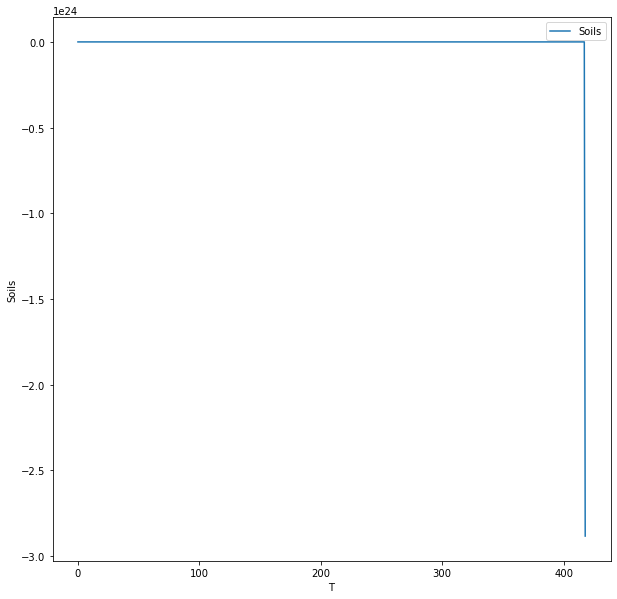

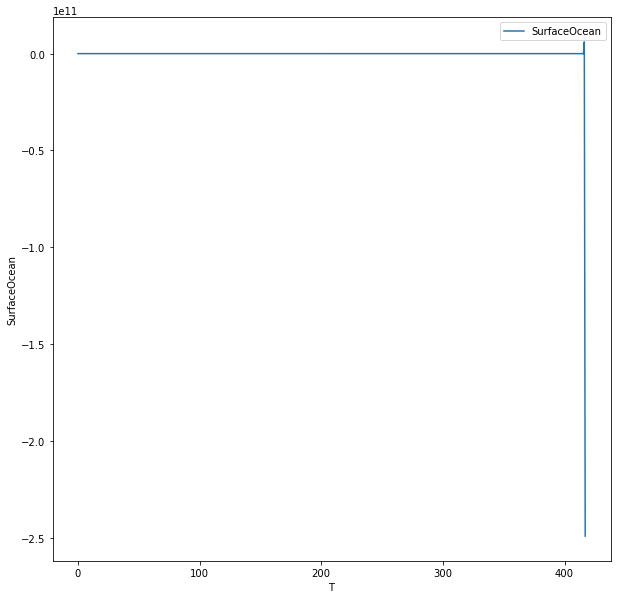

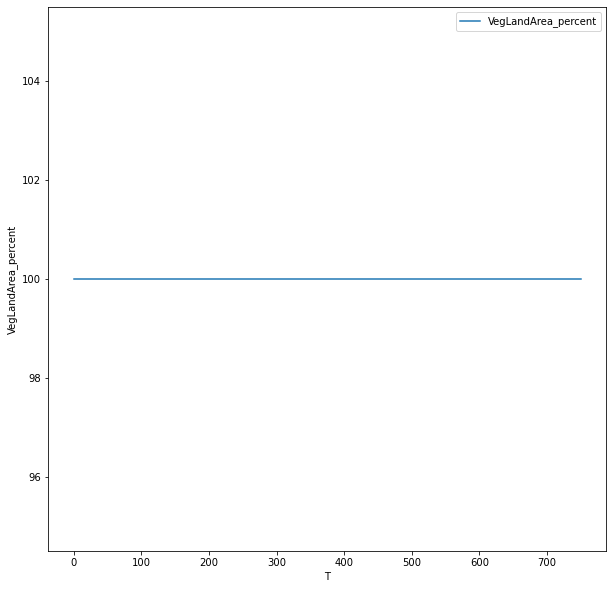

In [10]:
#POUR LE SOILS, derivative[5], x[5], x0[5]
#dSoils_dt = Litterfall - Soils * (55/Soil_Initial)

# Atmosphere = x[0]
#CarbonateRock = x[1]
#DeepOcean = x[2]
#FossilFuelCarbon = x[3]
#Plants = x[4]
#Soils = x[5]
#SurfaceOcean = x[6]
#VegLandArea_percent = x[7]

def euler(F, t0,tf,y0, n): # y’=F(y,t) 
    h = (tf-t0)/n
    y = y0
    t = t0
    Y = [y0]
    T = [t0]
    for k in range(n): 
        y = y + h * F(y,t)
        t=t+h 
        Y.append(y) 
        T.append(t)
    return T,Y

#le y equivaut au vecteur x et au début y0 = x0 en vecteur, donc F c'est la fonction dérivative

T,Y = euler(derivative,0,750,x0,1000)

def Atmosphere():
    Atmo = []
    for i in range(1001):
        Atmo.append(Y[i][0])
    return Atmo

def CarboRock():
    L=[]
    for i in range(1001):
        L.append(Y[i][1])
    return L

DeepOcean = [Y[i][2] for i in range(1001)]
FossilFuelCarbon = [Y[i][3] for i in range(1001)]
Plants = [Y[i][4] for i in range(1001)]
Soils = [Y[i][4] for i in range(1001)]
SurfaceOcean = [Y[i][6] for i in range(1001)]
VegLandArea_percent = [Y[i][7] for i in range(1001)]
Atmosphere1=Atmosphere()
CarbonateRock = CarboRock()

plt.figure(figsize=(10,10))
plt.plot(T,Atmosphere1,label = 'Atmosphère1')
plt.xlabel('T')
plt.ylabel('Atmosphere')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(T,CarbonateRock,label = 'CarbonateRock')
plt.xlabel('T')
plt.ylabel('CarboRock')
plt.legend()
plt.show()


plt.figure(figsize=(10,10))
plt.plot(T,DeepOcean,label = 'DeepOcean')
plt.xlabel('T')
plt.ylabel('DeepOcean')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(T,FossilFuelCarbon,label = 'FossilFuelCarbon')
plt.xlabel('T')
plt.ylabel('FossilFuelCarbon')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(T,Plants,label = 'Plants')
plt.xlabel('T')
plt.ylabel('Plants')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(T,Soils,label = 'Soils')
plt.xlabel('T')
plt.ylabel('Soils')
plt.legend()
plt.show()


plt.figure(figsize=(10,10))
plt.plot(T,SurfaceOcean,label = 'SurfaceOcean')
plt.xlabel('T')
plt.ylabel('SurfaceOcean')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(T,VegLandArea_percent,label = 'VegLandArea_percent')
plt.xlabel('T')
plt.ylabel('VegLandArea_percent')
plt.legend()
plt.show()

Methode Runge Kunta q=4

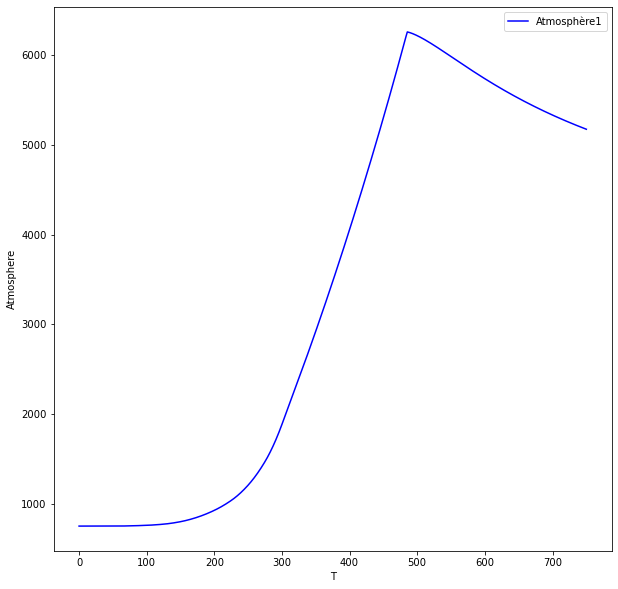

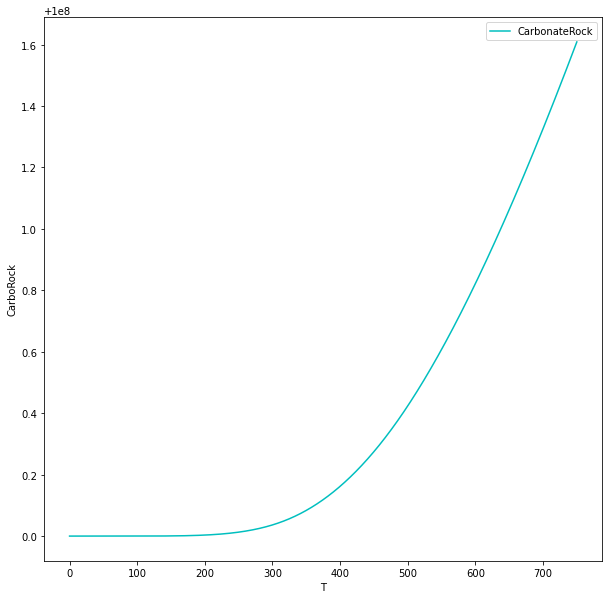

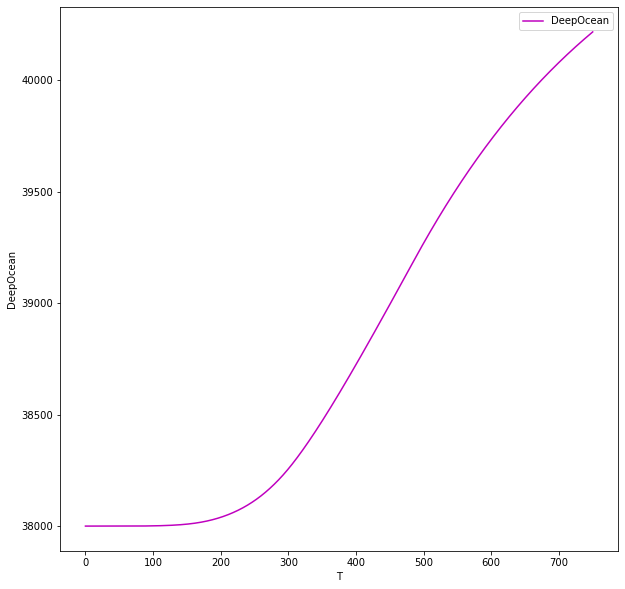

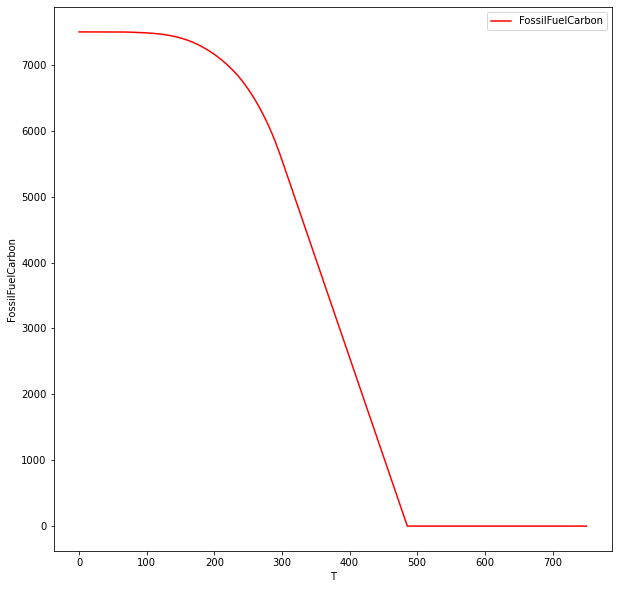

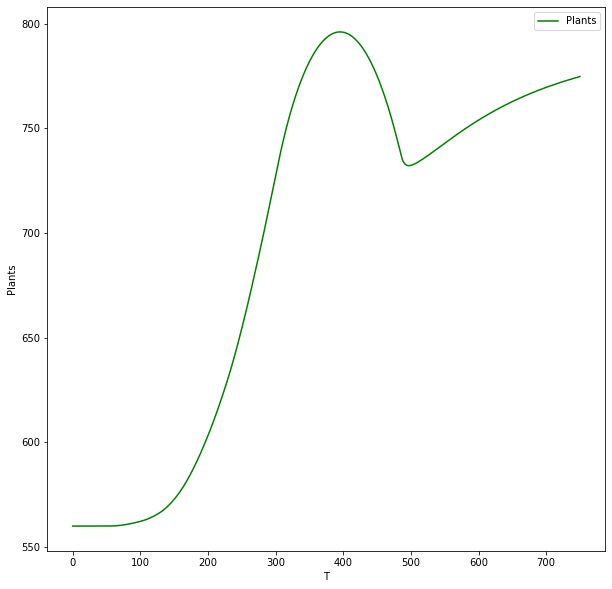

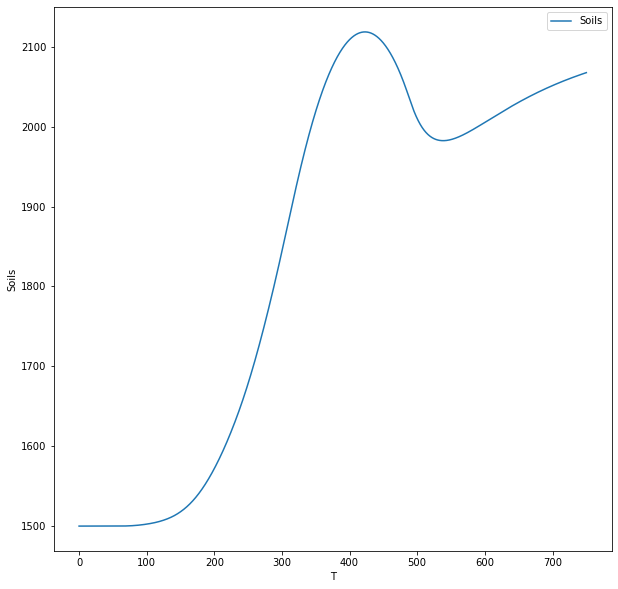

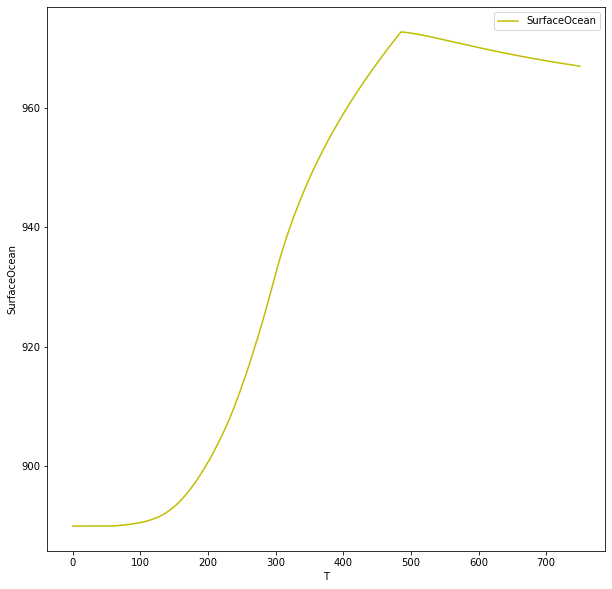

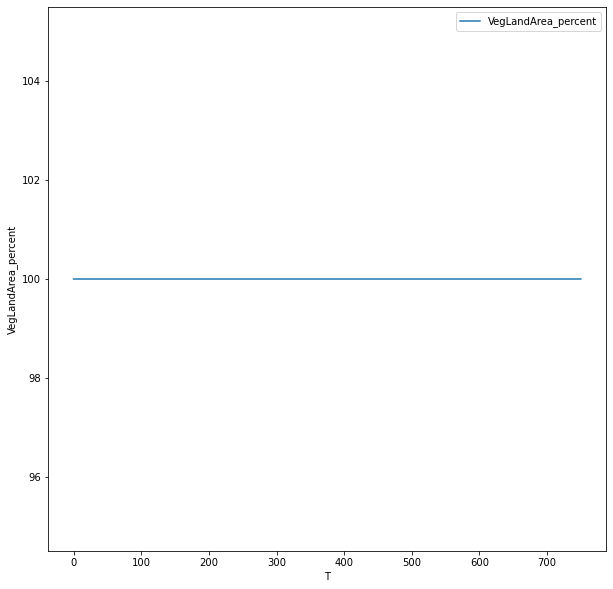

In [13]:
def rungekutta4_step(f, y0, start, end, step, args=()):
    n = int(abs(start - end)/step)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    c = np.zeros(4)
    T = [start+i*step for i in range(n+1)]
    for i in range(n - 1):
        k1 = f(y[i], T[i])
        k2 = f(y[i] + k1 * step/2, T[i])
        k3 = f(y[i] + k2 * step/2, T[i])
        k4 = f(y[i] + k3 * step, T[i])
        y[i+1] = y[i] + (step/6) * (k1 + 2*k2 + 2*k3 + k4)
        

    return y


Y = rungekutta4_step(derivative, x0, 0, 750, 0.05)
T = np.linspace(0,750,int(750/0.05))


plt.figure(figsize=(10,10))
plt.plot(T,Y[:,0],label = 'Atmosphère1',color='b')
plt.xlabel('T')
plt.ylabel('Atmosphere')
plt.legend()


plt.figure(figsize=(10,10))
plt.plot(T,Y[:,1],label = 'CarbonateRock',color='c')
plt.xlabel('T')
plt.ylabel('CarboRock')
plt.legend()



plt.figure(figsize=(10,10))
plt.plot(T,Y[:,2],label = 'DeepOcean',color='m')
plt.xlabel('T')
plt.ylabel('DeepOcean')
plt.legend()


plt.figure(figsize=(10,10))
plt.plot(T,Y[:,3],label = 'FossilFuelCarbon',color='r')
plt.xlabel('T')
plt.ylabel('FossilFuelCarbon')
plt.legend()


plt.figure(figsize=(10,10))
plt.plot(T,Y[:,4],label = 'Plants',color='g')
plt.xlabel('T')
plt.ylabel('Plants')
plt.legend()


plt.figure(figsize=(10,10))
plt.plot(T,Y[:,5],label = 'Soils')
plt.xlabel('T')
plt.ylabel('Soils')
plt.legend()



plt.figure(figsize=(10,10))
plt.plot(T,Y[:,6],label = 'SurfaceOcean',color='y')
plt.xlabel('T')
plt.ylabel('SurfaceOcean')
plt.legend()


plt.figure(figsize=(10,10))
plt.plot(T,Y[:,7],label = 'VegLandArea_percent')
plt.xlabel('T')
plt.ylabel('VegLandArea_percent',color='k')
plt.legend()
plt.show()
